In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis
import time
import scipy.stats
import copy
import statsmodels
from statsmodels.stats.anova import AnovaRM

root = '/usr/local/serenceslab/maggie/shapeDim/'
sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils, plot_utils, stats_utils, grid_utils

In [2]:
import bootstrap_confidence_binary
bootstrap_confidence_binary.bootstrap_correct_incorrect(n_boot_iter = 1000)

0
1
2
3
4
5
6


In [4]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 7
subjects = np.arange(1,8)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [5]:
lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)
   

In [6]:
from code_utils import grid_utils
grid_pts = grid_utils.get_main_grid()
# NOTE i am swapping the columns here
# because this is the order you get from doing np.unique(pts)
# this is the actual order that the predictions 1-16 of this classifier
# correspond to. 
grid_pts = grid_pts[:,[1,0]] 

In [7]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_binary_withintask.npy')
dec_withintask = np.load(save_filename, allow_pickle=True).item()
dec_withintask.keys()
roi_names = dec_withintask['roi_names']
n_rois = len(roi_names)

#### compute bootstrapped CIs for the correct/incorrect difference
on hard trials only

In [8]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
fn2load = os.path.join(save_folder, 'decode_binary_sepcorrect_bootstrap.npy')

b = np.load(fn2load, allow_pickle=True).item()
b.keys()
signedconf_hardtrials_sepcorrect_boot = b['signedconf_hardtrials_sepcorrect_boot']

In [9]:
signedconf_hardtrials_sepcorrect_boot.shape

(7, 8, 3, 2, 1000)

Text(0.5, 0.98, 'Hard trials: classifier confidence')

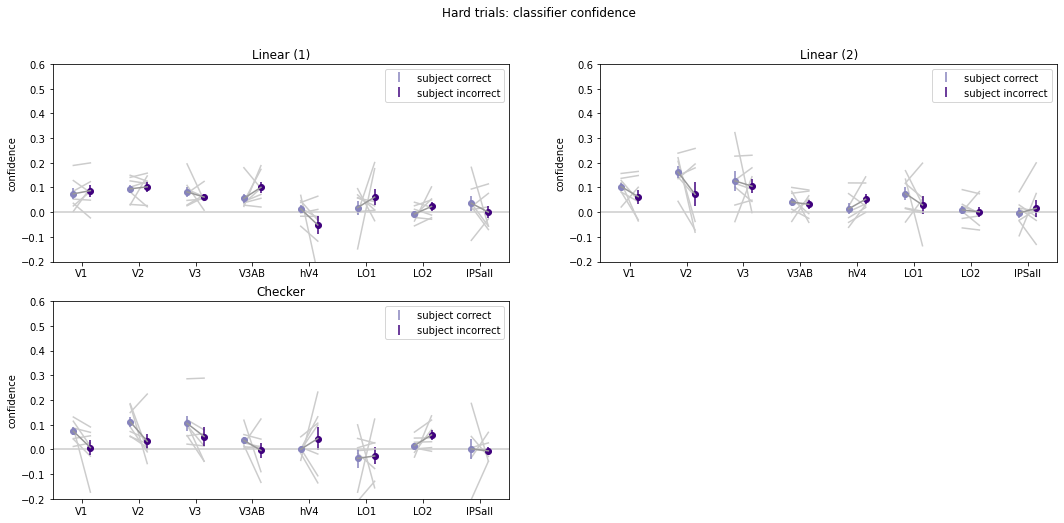

In [10]:
vals = np.mean(signedconf_hardtrials_sepcorrect_boot, axis=4)
meanvals = np.mean(vals, axis=0)
semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)


colors = cm.Purples(np.linspace(0,1,6))[[3,5],:]

x_jitter = np.linspace(-0.15, 0.15, 2)

plt.figure(figsize=(18,8))

for ti in [0,1,2]:
    
    plt.subplot(2,2,ti+1)
    
    plt.axhline(0, color=[0.8, 0.8, 0.8])
    
    lh = []
    
    for ci in [0,1]:
        
        x_ticks = np.arange(n_rois) + x_jitter[ci]
    
        plt.plot(x_ticks, meanvals[:,ti,ci], 'o', color=colors[ci])
        h = plt.errorbar(x_ticks, meanvals[:,ti,ci], \
                         semvals[:,ti,ci], \
                         xerr=None, color=colors[ci], linestyle='none')
        lh.append(h)
        
    for ri in range(n_rois):
            
        plt.plot(ri+x_jitter, meanvals[ri,ti,:],'-',color=[0.6, 0.6, 0.6])
        
        plt.plot(ri+x_jitter, vals[:,ri,ti,:].T, color=[0.8, 0.8, 0.8], zorder=-10)
        # if non_overlapping[ri]:
        #     yval = np.max(cihigh[ri,ti,:])+0.02
        #     plt.annotate('*',[ri,yval])

    plt.ylim([-0.20, 0.60])
    # plt.ylim([-0.05, 0.20])
    
    plt.xticks(np.arange(n_rois), roi_names)
    plt.ylabel('confidence')
    
    plt.legend(lh,['subject correct','subject incorrect'])
    
    plt.title(task_names[ti])
    
plt.suptitle('Hard trials: classifier confidence')


In [11]:
for ti, taskname in enumerate(task_names[0:3]):

    vals = np.mean(signedconf_hardtrials_sepcorrect_boot, axis=4)[:,:,ti,:]

    anova_result = stats_utils.rmanova_2way(vals, ['roi','correctness'], do_shuffle=False)
    
    print('\n%s'%taskname)
    print(anova_result)


Linear (1)
                  F Value  Num DF  Den DF    Pr > F
roi              5.545094     7.0    42.0  0.000144
correctness      0.038394     1.0     6.0  0.851121
roi:correctness  1.109563     7.0    42.0  0.375119

Linear (2)
                  F Value  Num DF  Den DF    Pr > F
roi              7.736056     7.0    42.0  0.000005
correctness      0.716624     1.0     6.0  0.429718
roi:correctness  1.425119     7.0    42.0  0.220976

Checker
                  F Value  Num DF  Den DF    Pr > F
roi              2.686479     7.0    42.0  0.021534
correctness      0.907657     1.0     6.0  0.377523
roi:correctness  1.421032     7.0    42.0  0.222558


In [12]:
for ti in range(3):

    vals = np.mean(signedconf_hardtrials_sepcorrect_boot, axis=4)[:,:,ti,:]

    tstats_correctness = np.zeros((n_rois,),dtype=float)
    pvals_correctness = np.zeros((n_rois,),dtype=float)
    pvals_nonpar_correctness = np.zeros((n_rois,),dtype=float)
    n_subs_samedir = np.zeros((n_rois,),dtype=int)

    rndseed = 223234
    for rr in range(n_rois):

        c1_values = vals[:,rr,0]
        c2_values = vals[:,rr,1]

        stats = scipy.stats.ttest_rel(c1_values, c2_values)

        tstats_correctness[rr] = stats.statistic
        pvals_correctness[rr] = stats.pvalue

        p, d = stats_utils.paired_ttest_nonpar(c1_values, c2_values, \
                                               n_iter=10000, rndseed=rndseed)    
        pvals_nonpar_correctness[rr] = p

        subj_diffs = c1_values - c2_values
        n_subs_samedir[rr] = np.maximum(np.sum(subj_diffs>0), np.sum(subj_diffs<0))

    p_values = pvals_nonpar_correctness
  
    corr_df = pd.DataFrame({'t-stat for correct > incorrect': tstats_correctness, \
                            'pvalue': p_values, \
                            'n_subs_indiv': n_subs_samedir}, \
                              index=roi_names)
    corr_df = corr_df.round(3)
    
    print('\n%s'%task_names[ti])
    print(corr_df)


Linear (1)
        t-stat for correct > incorrect  pvalue  n_subs_indiv
V1                              -0.611   0.635             4
V2                              -0.395   0.755             4
V3                               0.737   0.498             4
V3AB                            -1.409   0.229             5
hV4                              1.467   0.115             5
LO1                             -0.697   0.556             4
LO2                             -1.389   0.228             4
IPSall                           0.842   0.476             4

Linear (2)
        t-stat for correct > incorrect  pvalue  n_subs_indiv
V1                               1.340   0.242             4
V2                               1.697   0.153             4
V3                               0.371   0.723             4
V3AB                             0.333   0.743             4
hV4                             -1.844   0.154             5
LO1                              0.965   0.446             5
